# Idea

Statistical arbitrage through pairs trading with cointegrated pairs:
  - Time horizon of data: 4h, 8h, 12h, 24h, 48h
  - Method of identification of cointegrated pairs
      - Fixed set of cointegrated pairs calculated from a training period
      - Dynamically determined cointegrated pairs calculated each period or every several periods
  - Method of hedge-ratio calculation:
      - Pairs with a fixed hedge ratio calculated from a training period
      - Pairs with a dynamic hedge ratio calculated from a look-back period
  - Significance level for being considered cointegrated:
      - 0.10
      - 0.05
      - 0.02
  - Entry and exit levels
  - Lookback window length to calculate z-score (presumably shorter than window to calculate dynamic hedge ratio)


Separate idea:
  - Use price for cointegration or use returns for cointegration
  
  
Also consider baskets instead.

# Methodology

To be filled in: detail the steps, including data acquisition, cointegration testing, and the backtesting process.

# Results

To be filled in: summarize the key performance metrics you calculated.

# Future Work

To be filled in: mention potential improvements, such as adding more pairs, optimizing entry/exit rules, or incorporating more advanced statistical models like the Kalman filter.

Relevant sources:
  - https://medium.com/@trading.dude/unlocking-the-hidden-potential-using-statistical-arbitrage-as-an-indicator-in-python-a8595392def4
  - https://github.com/nirajdsouza/statistical-arbitage-strategy

# Imports

In [1]:
# import yfinance as yf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from binance.client import Client as bnb_client
from datetime import datetime
from statsmodels.tsa.stattools import coint

from ipynb.fs.full.utility_functions import (
    get_train_test_data,
    get_alpha_beta_to_asset,
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Get Historical Data For Cryptocurrencies

In [2]:
# The universe is based on this snapshot from December 20, 2020: https://coinmarketcap.com/historical/20201220/

univ = [
    "BTCUSDT", "ETHUSDT", "ADAUSDT", "BNBUSDT", "XRPUSDT", "DOTUSDT", "MATICUSDT", "LTCUSDT", "BCHUSDT",
    "LINKUSDT", "XLMUSDT", "USDCUSDT", "EOSUSDT", "TRXUSDT", "XTZUSDT", "FILUSDT", "NEOUSDT", "DAIUSDT",
    "DASHUSDT", "VETUSDT", "ATOMUSDT", "AAVEUSDT", "UNIUSDT", "GRTUSDT", "THETAUSDT", "IOTAUSDT", "BUSDUSDT",
    "ZECUSDT", "YFIUSDT", "ETCUSDT", "WAVESUSDT", "COMPUSDT", "SNXUSDT", "DOGEUSDT", "MKRUSDT", "ZILUSDT",
    "SUSHIUSDT", "KSMUSDT", "OMGUSDT", "ONTUSDT", "ALGOUSDT", "EGLDUSDT", "BATUSDT", "DGBUSDT", "ZRXUSDT",
    "TUSDUSDT", "QTUMUSDT", "ICXUSDT", "AVAXUSDT", "RENUSDT", "HBARUSDT", "NEARUSDT", "LRCUSDT", "CELOUSDT",
    "KNCUSDT", "LSKUSDT", "OCEANUSDT", "QNTUSDT", "USTUSDT", "BANDUSDT", "MANAUSDT", "ENJUSDT", "ANTUSDT",
    "BNTUSDT", "ZENUSDT", "NMRUSDT", "RVNUSDT", "IOSTUSDT", "OXTUSDT", "CRVUSDT", "MATICUSDT", "HNTUSDT",
    "BALUSDT", "CHZUSDT"
]

should_download_stock_data = False

In [3]:
client = bnb_client(tld='US')

def get_binance_px(symbol, freq, start_ts = '2020-12-20'):
    data = client.get_historical_klines(symbol, freq, start_ts)
    columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume',
               'num_trades', 'taker_base_volume', 'taker_quote_volume', 'ignore']
    data = pd.DataFrame(data, columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    return data 


if should_download_stock_data:
    freq = '4h'
    px = {}
    for x in univ:
        print(f"Downloading data for symbol {x}")
        data = get_binance_px(x, freq)
        px[x] = data.set_index('open_time')['close']

    px = pd.DataFrame(px).astype(float)
    px.to_csv('./class_project_input_prices.csv')
else:
    px = pd.read_csv('./class_project_input_prices.csv')
    date_format = "%Y-%m-%d %H:%M:%S"
    px['open_time'] = px['open_time'].apply(lambda t:  datetime.strptime(t, date_format))
    px.set_index('open_time', inplace=True)

# Data up to 2025-08-31 08:00:00
px_popular = px[["BTCUSDT", "ETHUSDT", "LTCUSDT", "XRPUSDT", "ADAUSDT"]]

In [4]:
t = datetime(2024, 1, 1, 0, 0)

popular_train_px, popular_test_px = get_train_test_data(px_popular, t)

# Identifying cointegrated pairs

In [5]:
def find_cointegrated_pairs(data, significance_level=0.05):
    """
    Finds cointegrated pairs using the Engle-Granger two-step method.
    Returns a list of cointegrated pairs with their p-value.
    """
    n = data.shape[1]
    keys = data.columns
    pvalue_matrix = pd.DataFrame(np.ones((n, n)), index=keys, columns=keys)
    pairs = []

    for i in range(n):
        for j in range(i + 1, n):
            series1 = data[keys[i]]
            series2 = data[keys[j]]
            
            joint_non_na_series1 = series1.loc[series1.notna() & series2.notna()]
            joint_non_na_series2 = series2.loc[series1.notna() & series2.notna()]
            
            if len(joint_non_na_series1) == 0 or len(joint_non_na_series2) == 0:
                pairs.append((keys[i], keys[j], 1.0))
                continue

            # Perform the cointegration test
            score, pvalue, _ = coint(joint_non_na_series1, joint_non_na_series2)
            pvalue_matrix.loc[keys[i], keys[j]] = pvalue

            if pvalue < significance_level:
                pairs.append((keys[i], keys[j], pvalue))
    return pvalue_matrix, pairs

In [ ]:
# Find the cointegrated pairs
pvalue_matrix, cointegrated_pairs = find_cointegrated_pairs(popular_train_px)

Cointegration Test P-value Matrix:


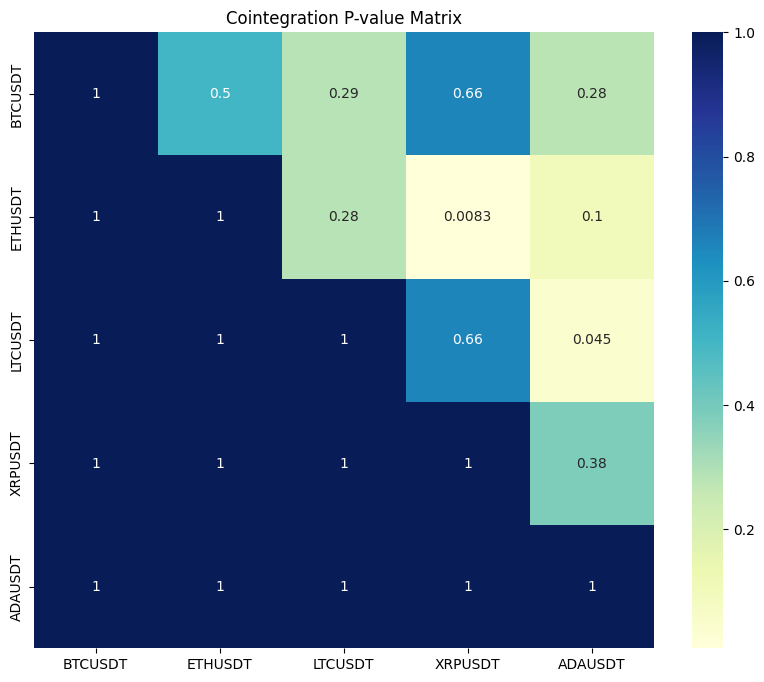


Found Cointegrated Pairs:
Pair: ETHUSDT and XRPUSDT, P-value: 0.0083
Pair: LTCUSDT and ADAUSDT, P-value: 0.0454


In [7]:
print("Cointegration Test P-value Matrix:")
plt.figure(figsize=(10, 8))
sns.heatmap(pvalue_matrix, xticklabels=pvalue_matrix.columns, yticklabels=pvalue_matrix.columns, cmap='YlGnBu', annot=True)
plt.title('Cointegration P-value Matrix')
plt.show()

print("\nFound Cointegrated Pairs:")
for pair in cointegrated_pairs:
    print(f"Pair: {pair[0]} and {pair[1]}, P-value: {pair[2]:.4f}")

In [18]:
def get_cointegrated_pairs_with_window(
    training_px,
    num_look_back_periods,
    num_periods_between_recalculation,
    significance_level
):
    time_to_cointegrated_pairs = dict()
    df_index = training_px.index
    for index in range(0, len(training_px), num_periods_between_recalculation):
        look_back_index = max(0, index - num_look_back_periods)
        if look_back_index == 0:
            continue
        input_px = training_px.iloc[look_back_index:index]
        
        time_to_cointegrated_pairs[df_index[index]] = find_cointegrated_pairs(input_px, significance_level)[1]
    return time_to_cointegrated_pairs

In [ ]:
all_cointegrations = get_cointegrated_pairs_with_window(popular_train_px, 6 * 7 * 8, 6 * 7, 0.05)

In [22]:
all_cointegrations

{Timestamp('2021-02-21 00:00:00'): [('BTCUSDT',
   'ADAUSDT',
   0.0401451280283487)],
 Timestamp('2021-02-28 00:00:00'): [],
 Timestamp('2021-03-07 00:00:00'): [('XRPUSDT',
   'ADAUSDT',
   1.979605387702764e-05)],
 Timestamp('2021-03-14 00:00:00'): [('BTCUSDT', 'XRPUSDT', 1.0),
  ('ETHUSDT', 'XRPUSDT', 1.0),
  ('LTCUSDT', 'XRPUSDT', 1.0),
  ('XRPUSDT', 'ADAUSDT', 1.0)],
 Timestamp('2021-03-21 00:00:00'): [('BTCUSDT', 'XRPUSDT', 1.0),
  ('ETHUSDT', 'XRPUSDT', 1.0),
  ('LTCUSDT', 'XRPUSDT', 1.0),
  ('XRPUSDT', 'ADAUSDT', 1.0)],
 Timestamp('2021-03-28 00:00:00'): [('BTCUSDT', 'XRPUSDT', 1.0),
  ('ETHUSDT', 'XRPUSDT', 1.0),
  ('LTCUSDT', 'XRPUSDT', 1.0),
  ('XRPUSDT', 'ADAUSDT', 1.0)],
 Timestamp('2021-04-04 00:00:00'): [('BTCUSDT', 'XRPUSDT', 1.0),
  ('ETHUSDT', 'XRPUSDT', 1.0),
  ('LTCUSDT', 'XRPUSDT', 1.0),
  ('XRPUSDT', 'ADAUSDT', 1.0)],
 Timestamp('2021-04-11 00:00:00'): [('BTCUSDT', 'XRPUSDT', 1.0),
  ('ETHUSDT', 'XRPUSDT', 1.0),
  ('LTCUSDT', 'XRPUSDT', 1.0),
  ('XRPUSDT', 'ADAUSD

# Calculate Hedge Ratio

In [ ]:
def calculate_hedge_ratio_at_index(px_df, index, num_look_back_periods, dependent_coin, independent_coin):
    start_index = max(0, index - num_look_back_periods)
    dependent_data = px_df[dependent_coin].iloc[start_index:index]
    independent_data = px_df[independent_coin].iloc[start_index:index]
    
    alpha, beta = get_alpha_beta_to_asset(dependent_data, independent_data)
    return beta

- Time horizon of data: 4h, 8h, 12h, 24h, 48h
- Method of identification of cointegrated pairs
    - Fixed set of cointegrated pairs calculated from a training period
    - Dynamically determined cointegrated pairs calculated each period or every several periods
- Method of hedge-ratio calculation:
    - Pairs with a fixed hedge ratio calculated from a training period
    - Pairs with a dynamic hedge ratio calculated from a look-back period
- Significance level for being considered cointegrated:
    - 0.10
    - 0.05
    - 0.02
- Entry and exit levels
- Lookback window length to calculate z-score (presumably shorter than window to calculate dynamic hedge ratio)

Separate idea:
- Use price for cointegration or use returns for cointegration

In [25]:
def get_returns_from_dynamic_cointegration(time_horizon_hours, px_df):
    pass


# px is expected to have data for every 4 hours
def get_horizon_to_px(px_df):
    start_time = px_df.index[0]
    end_time = px_df.index[-1]
    return {
        4: px_df,
        8: px_df[px_df.index.hour % 8 == 0],
        12: px_df[px_df.index.hour % 12 == 0],
        24: px_df[px_df.index.hour == 0],
        48: px_df[px_df.index.hour == 0].loc[pd.date_range(start=start_time, end=end_time, freq='2D')],
    }


# original_px_df should have data for every 4 hours
def get_all_gross_returns_and_net_returns(original_px_df):
    # return map from variations to pair of dataframes of gross returns and net returns
    variation_to_returns = dict()
    
    horizon_to_px = get_horizon_to_px(original_px_df)
    for time_horizon_hours in (4, 8, 12, 24, 48):
        dynamic_cointegration_map = get_returns_from_dynamic_cointegration(
            time_horizon_hours, horizon_to_px[time_horizon_hours]
        )
    
        variation_to_returns.update(dynamic_cointegration_map)

    return variation_to_returns

In [9]:


# def get_gross_and_net_returns_for_all_dynamic_cointegration_combinations(px):
#     horizon_to_px = get_horizon_to_px(px, datetime(2020, 12, 20), datetime(2023, 12, 31))
    
#     for num_hours in (4, 8, 12, 24, 48):
#         train_px_horizon = horizon_to_px[num_hours]
    
#         significance_level = 0.05
#         num_periods_between_recalculation = 24 / num_hours * 30
#         num_look_back_periods = 2 * num_periods_between_recalculation
        
#         time_to_cointegrated_pairs = get_cointegrated_pairs_with_window(
#             train_px_horizon, num_look_back_periods, num_periods_between_recalculation, significance_level)
        
        

    
# def get_gross_and_net_returns_for_fixed_cointegration_combinations(px):
#     pass

In [ ]:
horizon_to_px = get_horizon_to_px(popular_train_px, datetime(2020, 12, 20), datetime(2023, 12, 31))

num_hours = 4

# for num_hours in (4, 8, 12, 24, 48):
#     train_px_horizon = horizon_to_px[num_hours]

#     significance_level = 0.05
#     num_periods_between_recalculation = 24 / num_hours * 30
#     num_look_back_periods = 2 * num_periods_between_recalculation

#     time_to_cointegrated_pairs = get_cointegrated_pairs_with_window(
#         train_px_horizon, num_look_back_periods, num_periods_between_recalculation, significance_level)

train_px_horizon = horizon_to_px[num_hours]

significance_level = 0.05
num_periods_between_recalculation = int(24 / num_hours * 30)
num_look_back_periods = 2 * num_periods_between_recalculation

time_to_cointegrated_pairs = get_cointegrated_pairs_with_window(
    train_px_horizon, num_look_back_periods, num_periods_between_recalculation, significance_level)

In [24]:
cointegration_identification_times = sorted(list(time_to_cointegrated_pairs.keys()))
cointegration_index = None
signal_map = dict()
date_index_arr = train_px_horizon.index


def get_updated_cointegration_index(cointegration_idx, time_idx, coint_id_times):
    if cointegration_idx is None:
        

for index in range(len(train_px_horizon)):
    time_index = date_index_arr[index]
    cointegration_index = get_updated_cointegration_index(cointegration_index, time_index, cointegration_identification_times)
    signal_map[time_index] = get_signal_at_index(index, time_index, train_px_horizon, cointegrated_pairs, hedge_map)

[Timestamp('2021-03-20 00:00:00'),
 Timestamp('2021-04-19 00:00:00'),
 Timestamp('2021-05-19 00:00:00'),
 Timestamp('2021-06-18 00:00:00'),
 Timestamp('2021-07-18 04:00:00'),
 Timestamp('2021-08-17 04:00:00'),
 Timestamp('2021-09-16 04:00:00'),
 Timestamp('2021-10-16 04:00:00'),
 Timestamp('2021-11-15 04:00:00'),
 Timestamp('2021-12-15 04:00:00'),
 Timestamp('2022-01-14 04:00:00'),
 Timestamp('2022-02-13 04:00:00'),
 Timestamp('2022-03-15 04:00:00'),
 Timestamp('2022-04-14 04:00:00'),
 Timestamp('2022-05-14 04:00:00'),
 Timestamp('2022-06-13 04:00:00'),
 Timestamp('2022-07-13 04:00:00'),
 Timestamp('2022-08-12 04:00:00'),
 Timestamp('2022-09-11 04:00:00'),
 Timestamp('2022-10-11 04:00:00'),
 Timestamp('2022-11-10 04:00:00'),
 Timestamp('2022-12-10 04:00:00'),
 Timestamp('2023-01-09 04:00:00'),
 Timestamp('2023-02-08 08:00:00'),
 Timestamp('2023-03-10 08:00:00'),
 Timestamp('2023-04-09 08:00:00'),
 Timestamp('2023-05-09 08:00:00'),
 Timestamp('2023-06-08 08:00:00'),
 Timestamp('2023-07-

# Backtesting the strategy for one pair


Backtesting the strategy for the pair: LTCUSDT and ADAUSDT
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_1125/3785399861.py:53: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  backtest_df['signal'] = backtest_df['signal'].replace(to_replace=0, method='ffill')


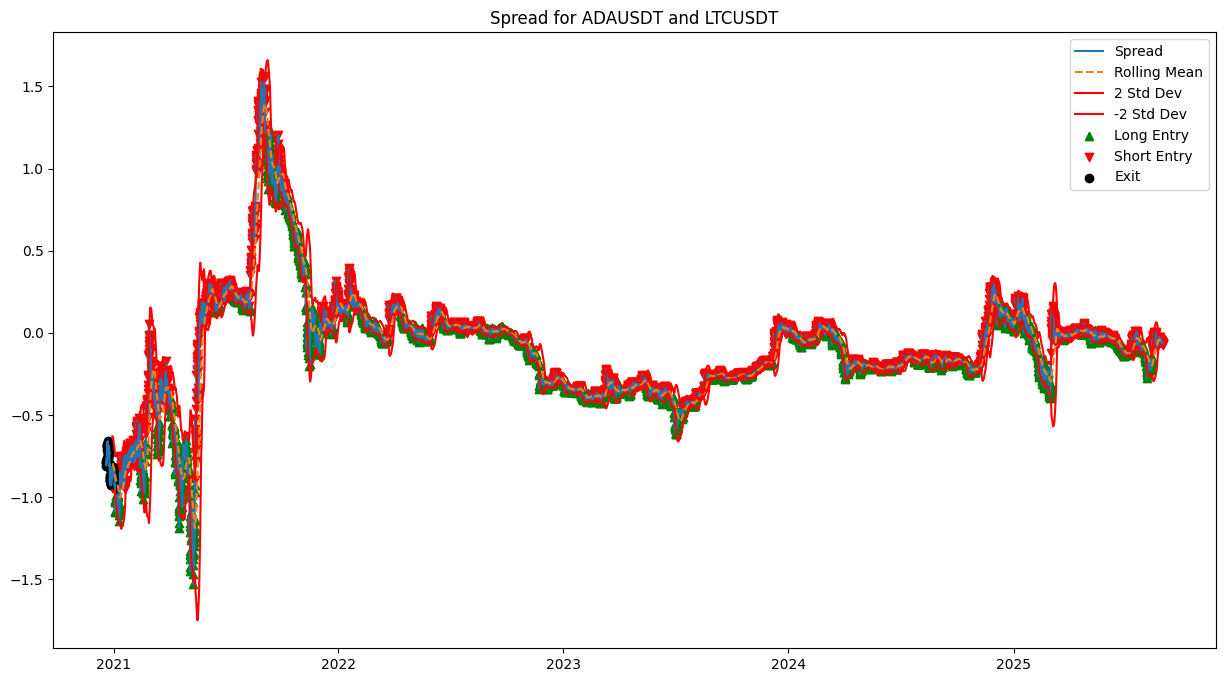

In [52]:
import statsmodels.api as sm

# --- Select a cointegrated pair for backtesting (e.g., BTC and ETH) ---
asset_x = 'LTCUSDT'
asset_y = 'ADAUSDT'

# Check if the selected pair is actually cointegrated
if (asset_x, asset_y, pvalue_matrix.loc[asset_x, asset_y]) in cointegrated_pairs or \
   (asset_y, asset_x, pvalue_matrix.loc[asset_y, asset_x]) in cointegrated_pairs:
    print(f"\nBacktesting the strategy for the pair: {asset_x} and {asset_y}")
else:
    print(f"\nWarning: The pair {asset_x} and {asset_y} is not found to be cointegrated at the 5% significance level.")
    print("Please choose a valid cointegrated pair from the previous step.")

# --- Calculate the hedge ratio and spread ---
# Perform a linear regression to find the hedge ratio
model = sm.OLS(px_popular[asset_y], sm.add_constant(px_popular[asset_x])).fit()
hedge_ratio = model.params[asset_x]
spread = px_popular[asset_y] - hedge_ratio * px_popular[asset_x]

# --- Backtesting logic ---
# Define trading parameters
window = 60 # Lookback window for mean and std dev
num_std_dev_entry = 2 # Number of standard deviations for entry
num_std_dev_exit = 0.5 # Number of standard deviations for exit

# Calculate rolling mean and standard deviation of the spread
rolling_mean = spread.rolling(window=window).mean()
rolling_std = spread.rolling(window=window).std()

# Calculate Bollinger Bands
upper_band = rolling_mean + num_std_dev_entry * rolling_std
lower_band = rolling_mean - num_std_dev_entry * rolling_std

# Create DataFrame for backtest
backtest_df = pd.DataFrame(index=spread.index)
backtest_df['spread'] = spread
backtest_df['rolling_mean'] = rolling_mean
backtest_df['rolling_std'] = rolling_std
backtest_df['upper_band'] = upper_band
backtest_df['lower_band'] = lower_band

# --- Generate trading signals ---
# Signal: 1 for long spread, -1 for short spread, 0 for no position
backtest_df['signal'] = 0.0
backtest_df.loc[backtest_df['spread'] > backtest_df['upper_band'], 'signal'] = -1.0
backtest_df.loc[backtest_df['spread'] < backtest_df['lower_band'], 'signal'] = 1.0

# Exit signal: close position when spread reverts to near the mean
backtest_df.loc[abs(backtest_df['spread']) < num_std_dev_exit * backtest_df['rolling_std'], 'signal'] = 0.0

# Forward-fill signals to hold positions
backtest_df['signal'] = backtest_df['signal'].replace(to_replace=0, method='ffill')

# --- Plot the spread and trading signals ---
plt.figure(figsize=(15, 8))
plt.plot(backtest_df.index, backtest_df['spread'], label='Spread')
plt.plot(backtest_df.index, backtest_df['rolling_mean'], label='Rolling Mean', linestyle='--')
plt.plot(backtest_df.index, backtest_df['upper_band'], label=f'{num_std_dev_entry} Std Dev', color='red')
plt.plot(backtest_df.index, backtest_df['lower_band'], label=f'-{num_std_dev_entry} Std Dev', color='red')
plt.title(f'Spread for {asset_y} and {asset_x}')

# Highlight entry and exit points
long_entries = backtest_df[backtest_df['signal'] == 1].index
short_entries = backtest_df[backtest_df['signal'] == -1].index
exits = backtest_df[backtest_df['signal'] == 0].index

plt.scatter(long_entries, backtest_df.loc[long_entries, 'spread'], marker='^', color='green', label='Long Entry')
plt.scatter(short_entries, backtest_df.loc[short_entries, 'spread'], marker='v', color='red', label='Short Entry')
plt.scatter(exits, backtest_df.loc[exits, 'spread'], marker='o', color='black', label='Exit')

plt.legend()
plt.show()

In [58]:
backtest_df.iloc[110:140]

,spread,rolling_mean,rolling_std,upper_band,lower_band,signal
open_time,,,,,,
2021-01-07 08:00:00,-1.033145,-0.923336,0.088658,-0.746020,-1.100652,1.0
2021-01-07 12:00:00,-1.051067,-0.926090,0.090029,-0.746033,-1.106148,1.0
2021-01-07 16:00:00,-1.069100,-0.929113,0.091748,-0.745618,-1.112608,1.0
2021-01-07 20:00:00,-1.059315,-0.932316,0.092895,-0.746527,-1.118105,1.0
2021-01-08 00:00:00,-0.987506,-0.934923,0.092198,-0.750528,-1.119318,1.0
2021-01-08 04:00:00,-0.998661,-0.937630,0.091634,-0.754362,-1.120898,1.0
2021-01-08 08:00:00,-1.070955,-0.941367,0.092433,-0.756500,-1.126233,1.0
2021-01-08 12:00:00,-1.088167,-0.945904,0.092852,-0.760199,-1.131609,1.0
2021-01-08 16:00:00,-1.071169,-0.950000,0.092868,-0.764264,-1.135735,1.0


# Performance evaluation

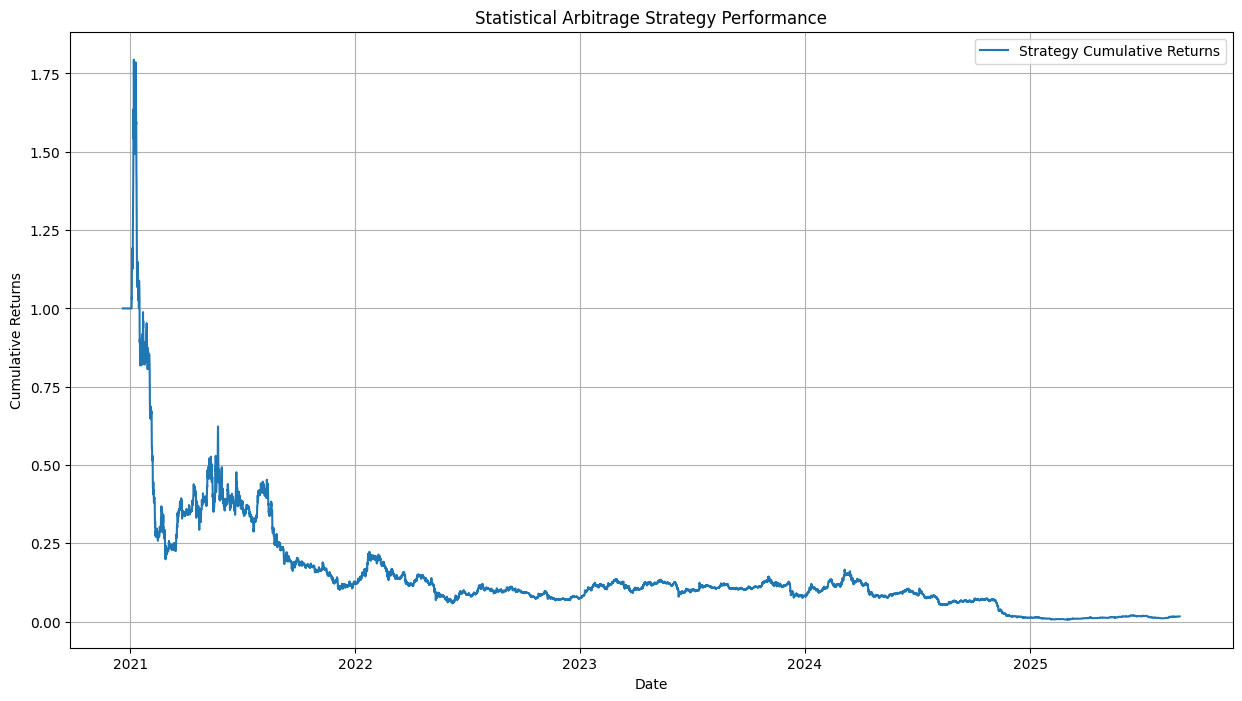


Strategy Performance Metrics:
Total Cumulative Return: -98.33%
Annualized Return: -0.06
Annualized Volatility: 0.40
Sharpe Ratio: -0.15


In [51]:
# --- Calculate daily returns of the assets ---
returns_x = px_popular[asset_x].pct_change()
returns_y = px_popular[asset_y].pct_change()

# --- Calculate strategy returns ---
# When 'signal' is 1 (long spread): long Y, short X
# When 'signal' is -1 (short spread): short Y, long X
strategy_returns = backtest_df['signal'].shift(1) * (returns_y - hedge_ratio * returns_x)

# --- Calculate cumulative returns ---
strategy_returns.dropna(inplace=True)
cumulative_returns = (1 + strategy_returns).cumprod()

# --- Plot cumulative returns ---
plt.figure(figsize=(15, 8))
plt.plot(cumulative_returns, label='Strategy Cumulative Returns')
plt.title('Statistical Arbitrage Strategy Performance')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

# --- Calculate performance metrics ---
total_return = (cumulative_returns.iloc[-1] - 1) * 100
annualized_return = (1 + strategy_returns.mean())**365 - 1
annualized_volatility = strategy_returns.std() * np.sqrt(365)
sharpe_ratio = annualized_return / annualized_volatility

print("\nStrategy Performance Metrics:")
print(f"Total Cumulative Return: {total_return:.2f}%")
print(f"Annualized Return: {annualized_return:.2f}")
print(f"Annualized Volatility: {annualized_volatility:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Second project

- https://www.pyquantnews.com/free-python-resources/event-driven-architecture-in-python-for-trading#:~:text=In%20the%20fast%2Dpaced%20realm,based%20on%20the%20latest%20information.
- https://github.com/topics/orderbook-tick-data
- https://medium.com/@gwrx2005/learning-without-retraining-implicit-in-context-learning-dynamics-for-adaptive-cryptocurrency-661ffeeaa489

Implementing a market-making simulation requires a more complex, event-driven framework than a simple backtest. It involves reconstructing an order book from historical tick data and processing events like new limit orders, cancellations, and trades as they occur. While a full-fledged simulation can be intricate, this code provides the core components for a simplified version. 

Prerequisites
For a real-world project, you'd need high-frequency, historical order book data, which can be acquired from data providers or cryptocurrency exchanges like Binance. This example uses simulated data for demonstration purposes. 

--- Market Making Simulation Summary ---
Starting Cash: $100000.00
Ending Cash: $16840336.76
Ending Inventory: -6.0000 BTC-USD
Final Portfolio Value (Estimate): $16476355.26


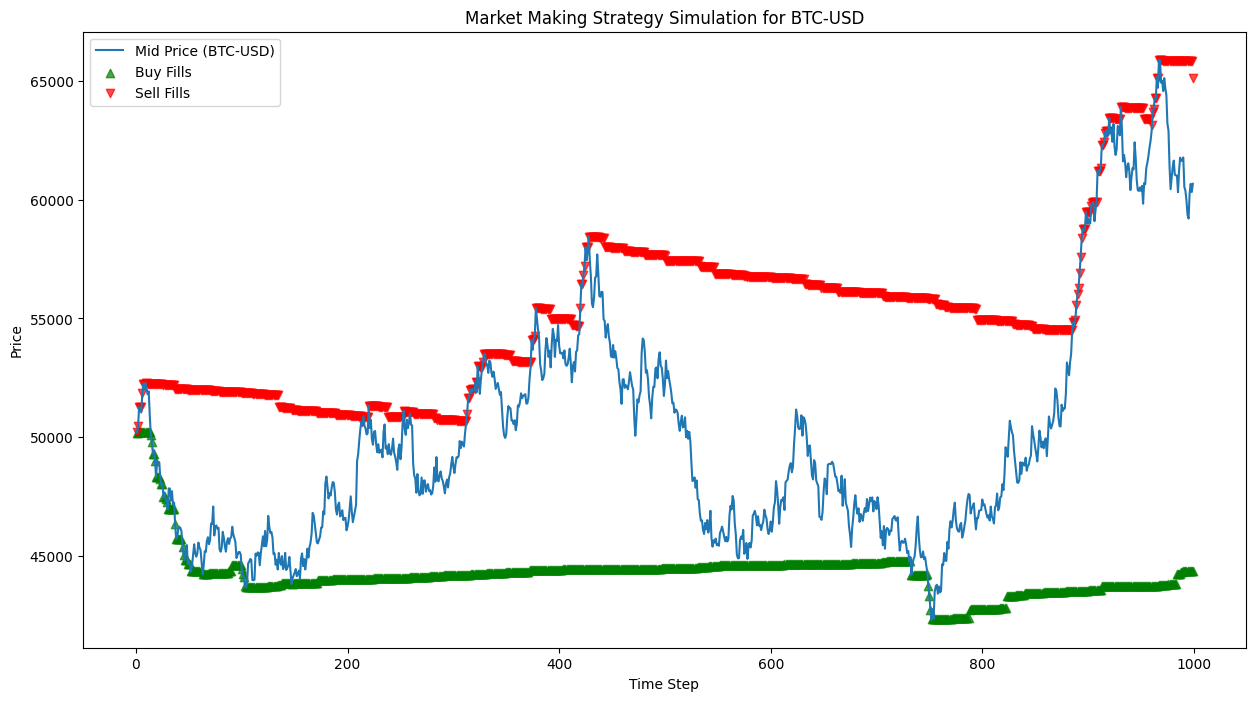

In [4]:
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt

class OrderBook:
    """
    A simplified Limit Order Book (LOB) class to manage bids and asks.
    """
    def __init__(self):
        self.bids = collections.OrderedDict()  # {price: quantity} - sorted descending
        self.asks = collections.OrderedDict()  # {price: quantity} - sorted ascending
    
    def add_order(self, order_id, side, price, quantity):
        if side == 'buy':
            if price in self.bids:
                self.bids[price] += quantity
            else:
                self.bids[price] = quantity
            # Sort bids descending
            self.bids = collections.OrderedDict(sorted(self.bids.items(), reverse=True))
        elif side == 'sell':
            if price in self.asks:
                self.asks[price] += quantity
            else:
                self.asks[price] = quantity
            # Sort asks ascending
            self.asks = collections.OrderedDict(sorted(self.asks.items()))

    def remove_order(self, order_id, side, price, quantity):
        if side == 'buy' and price in self.bids:
            self.bids[price] -= quantity
            if self.bids[price] <= 0:
                del self.bids[price]
        elif side == 'sell' and price in self.asks:
            self.asks[price] -= quantity
            if self.asks[price] <= 0:
                del self.asks[price]

    def process_trade(self, side, price, quantity):
        if side == 'buy':
            self.remove_order(None, 'sell', price, quantity)
        elif side == 'sell':
            self.remove_order(None, 'buy', price, quantity)

    def get_best_bid(self):
        return next(iter(self.bids.keys())) if self.bids else None
    
    def get_best_ask(self):
        return next(iter(self.asks.keys())) if self.asks else None

def simulate_market_making():
    """
    Simulates a simple market-making strategy based on a simplified order book.
    This example uses generated data to illustrate the process.
    In a real project, you would use historical order book tick data.
    """
    # --- Parameters for simulation ---
    num_steps = 1000
    asset_name = 'BTC-USD'
    inventory = 0  # Number of units of the asset held
    cash = 100000  # Starting cash in USD
    position = 0
    
    # --- Generate simulated order book data ---
    np.random.seed(42)
    mid_price_path = np.exp(np.random.randn(num_steps).cumsum() * 0.01) * 50000
    
    order_book = OrderBook()
    trades = []
    
    # --- Simulation loop ---
    for i in range(num_steps):
        mid_price = mid_price_path[i]
        
        # Add random bids and asks around the mid-price
        for _ in range(5):
            bid_price = mid_price * (1 - np.random.uniform(0.0001, 0.001))
            bid_qty = np.random.randint(1, 10)
            order_book.add_order(None, 'buy', bid_price, bid_qty)
            
            ask_price = mid_price * (1 + np.random.uniform(0.0001, 0.001))
            ask_qty = np.random.randint(1, 10)
            order_book.add_order(None, 'sell', ask_price, ask_qty)

        best_bid = order_book.get_best_bid()
        best_ask = order_book.get_best_ask()
        
        if best_bid is None or best_ask is None:
            continue
            
        # --- Market-Making Strategy ---
        # Place orders to capture the bid-ask spread
        my_bid_price = best_bid + 0.01
        my_ask_price = best_ask - 0.01
        
        # Check for fills (simplified)
        if best_ask <= my_bid_price:
            # My bid gets filled
            fill_price = best_ask
            fill_qty = np.random.randint(1, 3) # Random fill quantity
            cash -= fill_price * fill_qty
            inventory += fill_qty
            order_book.process_trade('buy', fill_price, fill_qty)
            trades.append({'time': i, 'price': fill_price, 'side': 'buy', 'qty': fill_qty})
            
        if best_bid >= my_ask_price:
            # My ask gets filled
            fill_price = best_bid
            fill_qty = np.random.randint(1, 3)
            cash += fill_price * fill_qty
            inventory -= fill_qty
            order_book.process_trade('sell', fill_price, fill_qty)
            trades.append({'time': i, 'price': fill_price, 'side': 'sell', 'qty': fill_qty})
        
        position = cash + inventory * mid_price
        
    # --- Backtest Summary ---
    print("--- Market Making Simulation Summary ---")
    print(f"Starting Cash: ${100000:.2f}")
    print(f"Ending Cash: ${cash:.2f}")
    print(f"Ending Inventory: {inventory:.4f} {asset_name}")
    print(f"Final Portfolio Value (Estimate): ${position:.2f}")

    # --- Plotting Results ---
    trade_prices = pd.DataFrame(trades)
    
    plt.figure(figsize=(15, 8))
    plt.plot(mid_price_path, label=f'Mid Price ({asset_name})')
    if not trade_prices.empty:
        buy_trades = trade_prices[trade_prices['side'] == 'buy']
        sell_trades = trade_prices[trade_prices['side'] == 'sell']
        plt.scatter(buy_trades['time'], buy_trades['price'], marker='^', color='green', label='Buy Fills', alpha=0.7)
        plt.scatter(sell_trades['time'], sell_trades['price'], marker='v', color='red', label='Sell Fills', alpha=0.7)
    
    plt.title(f'Market Making Strategy Simulation for {asset_name}')
    plt.xlabel('Time Step')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Run the simulation
simulate_market_making()